In [1]:
using Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import LinearAlgebra as LA
import SparseArrays as SA
import Plots
import Interpolations as IP
using LaTeXStrings
import QuantumOptics as QO

using FFTW:ifft, fft, fftshift, fftfreq

In [3]:
repo_path = "/local/lmseifert/Other/shaken_lattice_qoc/"
src_path = repo_path * "src/"
include(src_path * "utils.jl")
include(src_path * "system.jl")
include(src_path * "constraints.jl")
include(src_path * "objectives.jl")

QuadraticObjective (generic function with 3 methods)

# using QuantumOptics package

In [175]:
V = 10.
p_max = 10
system_momentum = ShakenLatticeSystem1D(V, p_max; bloch_basis=false)
mid = system_momentum.params[:mid]
dim = system_momentum.params[:dim]

21

In [176]:
n_max = 3
ns = -n_max:n_max
v = system_momentum.params[:bloch_states][ns .+ mid,1]

7-element Vector{ComplexF64}:
 0.0033487398896073126 - 0.0im
    0.0509792242548755 - 0.0im
   0.36682320079649994 - 0.0im
    0.8518575326168721 + 0.0im
    0.3668232007964992 - 0.0im
  0.050979224254875374 - 0.0im
 0.0033487398896073113 - 0.0im

In [177]:
x_max = 200.
Nx = 5000

5000

In [178]:
b_position = QO.PositionBasis(-x_max, x_max, Nx)
b_momentum = QO.MomentumBasis(b_position)

Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)

In [179]:
xs = QO.samplepoints(b_position)
ps = QO.samplepoints(b_momentum)

5000-element Vector{Float64}:
 -39.269908169872416
 -39.254200206604466
 -39.238492243336516
 -39.222784280068566
 -39.20707631680062
 -39.191368353532674
 -39.175660390264724
 -39.159952426996774
 -39.144244463728825
 -39.128536500460875
 -39.112828537192925
 -39.097120573924975
 -39.081412610657026
   ⋮
  39.08141261065703
  39.097120573924975
  39.11282853719293
  39.128536500460875
  39.14424446372883
  39.159952426996774
  39.17566039026473
  39.191368353532674
  39.20707631680062
  39.22278428006857
  39.238492243336516
  39.25420020660447

In [180]:
Txp = QO.transform(b_position, b_momentum)
Tpx = QO.transform(b_momentum, b_position)

FFTOperators(dim=5000x5000)
  basis left:  Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)
  basis right: Position(xmin=-200.0, xmax=200.0, N=5000)

In [181]:
p_op = QO.momentum(b_momentum)

Operator(dim=5000x5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,

In [182]:
acc = 0.01

0.0

In [183]:
H_kin_p = p_op^2
H_kin_x = QO.LazyProduct(Txp, H_kin_p, Tpx) + QO.potentialoperator(b_position, x -> -0.5*acc*x)

LazySum(dim=5000x5000)
  basis: Position(xmin=-200.0, xmax=200.0, N=5000)
  operators: 2

In [184]:
H_pot_I_x = QO.potentialoperator(b_position, x -> -V/2 * cos(2x))
H_pot_Q_x = QO.potentialoperator(b_position, x -> V/2 * sin(2x))
H_pot_I_p = QO.LazyProduct(Tpx, H_pot_I_x, Txp)
H_pot_Q_p = QO.LazyProduct(Tpx, H_pot_Q_x, Txp)

LazyProduct(dim=5000x5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)
  operators: 3

Z = NT.load_traj("interferometer/split_victor_opt2.jld2")

a, dts = Z.a, vec(Z.dts)
T = Z.T
times = cumsum(dts) - dts

In [ ]:
Z_split = NT.load_traj("interferometer/split_bloch78.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_bloch78_Z.jld2")

In [ ]:
flight_time = 2pi * 0.2
T_flight = Int(round(flight_time/2pi * 1000; digits=0))
dts_flight = fill(flight_time/(T_flight-1), T_flight)

In [ ]:
Z_fake = NT.NamedTrajectory(
    (
        a = hcat([1., 0.]),
        dts = Z_split.dts[:,1:1]
    );
    controls=(:a),
    timestep=:dts
)

In [ ]:
a, dts = get_interferometer(Z_split, Z_fake, dts_flight)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new

T_pad = 500
a_pad = vcat(ones(T_pad)', zeros(T_pad)')
dts_pad = fill(dts[1], T_pad)
a = hcat(a_pad, a, a_pad)
dts = vcat(dts_pad, dts, dts_pad)

T = size(a, 2)
times = cumsum(dts) - dts

a = vcat(ones(T)', zeros(T)')

Z = NT.load_traj("end2end/traj.jld2")

a, dts = Z.a, vec(Z.dts)
flight_time = 2pi * 2.0
T_flight = Int(round(flight_time/2pi; digits=0)) * 600
jumps = [(div(Z.T, 3), flight_time), (div(2*Z.T, 3), flight_time)]
jump_Ts = fill(T_flight, 2)
a, dts = get_controls_dts(a, dts, jumps, jump_Ts)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new
T = size(a, 2)
times = cumsum(dts) - dts

In [ ]:
I_itp = IP.interpolate(a[1,:], IP.BSpline(IP.Cubic(IP.Free(IP.OnCell()))))
Q_itp = IP.interpolate(a[2,:], IP.BSpline(IP.Cubic(IP.Free(IP.OnCell()))))

In [ ]:
function I(t)
    if t < times[end]
        return I_itp(t/times[end]*(T-1) + 1)
    else
        return 1.0
    end
end 
function Q(t)
    if t < times[end]
        return Q_itp(t/times[end]*(T-1) + 1)
    else
        return 0.0
    end
end 

function I(t)
    return 1.0
end
function Q(t)
    return 0.0
end

In [ ]:
H_x = QO.TimeDependentSum(1.0 => H_kin_x, I => H_pot_I_x, Q => H_pot_Q_x)
H_p = QO.TimeDependentSum(1.0 => H_kin_p, I => H_pot_I_p, Q => H_pot_Q_p)

In [ ]:
function gaussian_wavepacket(x, sigma)
    return (2*sigma^2/pi)^(1/4) * exp.(-sigma^2*x.^2)
end

In [ ]:
function wave(x, n)
    return exp.(2im*x*n')
end

In [ ]:
sigma = 0.2
psi0 = gaussian_wavepacket(xs, sigma) .* (wave(xs, ns) * v)
psi0_ket = QO.Ket(b_position, psi0)

In [ ]:
Plots.plot(xs, real.(psi0_ket.data))

t_max = 20.0
dt = 0.007
times = collect(0.0:dt:t_max)

In [ ]:
times_slice = 1:length(times)

In [ ]:
Plots.plot(times[times_slice], I.(times[times_slice]))

In [ ]:
tout, psit_ket = QO.timeevolution.schroedinger_dynamic(times[times_slice], psi0_ket, H_x)

In [ ]:
psi = hcat([psi_ket.data for psi_ket in psit_ket]...)
pops = abs2.(psi)

In [ ]:
x_step = 1

In [ ]:
sum_mat = blockdiagonal(fill(ones(1, x_step)/x_step, Int(ceil(Nx/x_step)))...)[:,1:Nx]

In [ ]:
pops[2501,:]

In [ ]:
pops2 = sum_mat * pops;

In [ ]:
Plots.heatmap(tout, xs[1:x_step:end], pops2, c=Plots.cgrad([:black, :white], [0.05]))

In [ ]:
t_step = 5

In [ ]:
pops_max = maximum(pops)

In [ ]:
anim = Plots.Animation()
for t=1:t_step:length(tout)
    p = Plots.plot(xs, pops[:,t], title="$(round(tout[t], digits=2))", ylim=(0.0, pops_max))
    Plots.frame(anim, p)
    println(t)
end

In [ ]:
Plots.gif(anim; fps=20, loop=0)

In [ ]:
psi0_p = fourier(psi0, xs, ps; exp_sign=-1)
psi0_ket_p = QO.Ket(b_momentum, psi0_p)

In [ ]:
tout_p, psit_ket_p = QO.timeevolution.schroedinger_dynamic(times[times_slice], psi0_ket_p, H_p)

In [ ]:
psi_p = hcat([psi_ket_p.data for psi_ket_p in psit_ket_p]...)
pops_p = abs2.(psi_p)

In [ ]:
psi_p_max = maximum([maximum(abs.(real.(psi_p))), maximum(abs.(imag.(psi_p)))])
pops_p_max = maximum(pops_p)

In [ ]:
anim = Plots.Animation()
for t=1:t_step:length(tout_p)
    p = Plots.plot(ps, pops_p[:,t], title="$(round(tout_p[t], digits=1))", ylim=(0.0, pops_p_max))
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim; fps=20, loop=0)

In [ ]:
anim = Plots.Animation()
for t=1:t_step:length(tout_p)
    p = Plots.plot(ps, real.(psi_p[:,t]), title="$(round(tout_p[t], digits=1))", ylim=(-psi_p_max, psi_p_max))
    Plots.plot!(p, ps, imag.(psi_p[:,t]), title="$(round(tout_p[t], digits=1))", ylim=(-psi_p_max, psi_p_max))
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim; fps=20, loop=0)

In [ ]:
anim = Plots.Animation()
for t=1:t_step:length(tout_p)
    p = Plots.path3d(ps, real.(psi_p[:,t]), imag.(psi_p[:,t]), ylim=(-psi_p_max, psi_p_max), zlim=(-psi_p_max, psi_p_max))
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim; fps=20, loop=0)

# Fisher

In [ ]:
V = 10.
p_max = 10
system_momentum = ShakenLatticeSystem1D(V, p_max; bloch_basis=false)
mid = system_momentum.params[:mid]
dim = system_momentum.params[:dim]

In [ ]:
n_max = 3
ns = -n_max:n_max
v = system_momentum.params[:bloch_states][ns .+ mid,1]

In [ ]:
x_max = 400.
Nx = 4000

In [ ]:
qb_basis = QO.GenericBasis(2)

In [ ]:
qb_10 = QO.projector(QO.Ket(qb_basis, [0,1]), QO.Bra(qb_basis, [1,0]))
qb_10_lift = QO.LazyTensor(b_mom_lift, [1], (qb_10,))

In [ ]:
b_position = QO.PositionBasis(-x_max, x_max, Nx)
b_momentum = QO.MomentumBasis(b_position)

In [ ]:
b_mom_lift = QO.tensor(qb_basis, b_momentum)
b_pos_lift = QO.tensor(qb_basis, b_position)

In [ ]:
xs = QO.samplepoints(b_position)
ps = QO.samplepoints(b_momentum)

In [ ]:
Txp

In [ ]:
Txp = QO.transform(b_pos_lift, b_mom_lift)
Tpx = QO.transform(b_mom_lift, b_pos_lift)

In [ ]:
p_op = QO.LazyTensor(b_mom_lift, [2], (QO.momentum(b_momentum),))

In [ ]:
H_kin_p_lift = p_op^2

In [ ]:
H_pot_I_x = QO.potentialoperator(b_position, x -> -V/2 * cos(2x))
H_pot_Q_x = QO.potentialoperator(b_position, x -> V/2 * sin(2x))
H_pot_I_x_lift = QO.LazyTensor(b_pos_lift, [2], (H_pot_I_x,))
H_pot_Q_x_lift = QO.LazyTensor(b_pos_lift, [2], (H_pot_Q_x,))
H_pot_I_p_lift = QO.LazyProduct(Tpx, H_pot_I_x_lift, Txp)
H_pot_Q_p_lift = QO.LazyProduct(Tpx, H_pot_Q_x_lift, Txp)

In [ ]:
H_a_x = QO.potentialoperator(b_position, x -> -0.5*x)
H_a_x_lift = QO.LazyTensor(b_pos_lift, [2], (H_a_x,))
H_a_p_lift = QO.LazyProduct(Tpx, H_a_x_lift, Txp)
H_a_p_lift = QO.LazyProduct(qb_10_lift, H_a_p_lift)

Z = NT.load_traj("interferometer/split_victor_opt2.jld2")

a, dts = Z.a, vec(Z.dts)
T = Z.T
times = cumsum(dts) - dts

In [ ]:
Z_split = NT.load_traj("interferometer/split_bloch78.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_bloch78_Z.jld2")

In [ ]:
flight_time = 2pi * 0.5
T_flight = Int(round(flight_time/2pi * 1000; digits=0))
dts_flight = fill(flight_time/(T_flight-1), T_flight)

In [ ]:
a, dts = get_interferometer(Z_split, Z_mirror, dts_flight)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new
T = size(a, 2)
times = cumsum(dts) - dts

In [ ]:
Z = NT.load_traj("end2end/traj.jld2")

In [ ]:
a, dts = Z.a, vec(Z.dts)
flight_time = 2pi * 2.0
T_flight = Int(round(flight_time/2pi; digits=0)) * 600
jumps = [(div(Z.T, 3), flight_time), (div(2*Z.T, 3), flight_time)]
jump_Ts = fill(T_flight, 2)
a, dts = get_controls_dts(a, dts, jumps, jump_Ts)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new
T = size(a, 2)
times = cumsum(dts) - dts

In [ ]:
I_itp = IP.interpolate(a[1,:], IP.BSpline(IP.Cubic(IP.Free(IP.OnCell()))))
Q_itp = IP.interpolate(a[2,:], IP.BSpline(IP.Cubic(IP.Free(IP.OnCell()))))

In [ ]:
function I(t)
    if t < times[end]
        return I_itp(t/times[end]*(T-1) + 1)
    else
        return 1.0
    end
end 
function Q(t)
    if t < times[end]
        return Q_itp(t/times[end]*(T-1) + 1)
    else
        return 0.0
    end
end 

function I(t)
    return 1.0
end
function Q(t)
    return 0.0
end

In [ ]:
H_p = QO.TimeDependentSum(1.0 => H_kin_p_lift, I => H_pot_I_p_lift, Q => H_pot_Q_p_lift, 1.0 => H_a_p_lift)

In [ ]:
function gaussian_wavepacket(x, sigma)
    return (2*sigma^2/pi)^(1/4) * exp.(-sigma^2*x.^2)
end

In [ ]:
function wave(x, n)
    return exp.(2im*x*n')
end

In [ ]:
sigma = 0.1
psi0 = gaussian_wavepacket(xs, sigma) .* (wave(xs, ns) * v)
psi0 = fourier(psi0, xs, ps; exp_sign=-1)
psi0_ket = QO.Ket(b_momentum, psi0)
psi0_ket = QO.tensor(QO.Ket(qb_basis, [1,0]), psi0_ket)

In [ ]:
Plots.plot(real.(psi0_ket.data[1:2:end]))

t_max = 20.0
dt = 0.007
times = collect(0.0:dt:t_max)

In [ ]:
times_slice = 1:length(times)

In [ ]:
Plots.plot(times[times_slice], I.(times[times_slice]))

In [ ]:
tout, psit_ket = QO.timeevolution.schroedinger_dynamic(times[times_slice], psi0_ket, H_p)

In [ ]:
psi = hcat([psi_ket.data for psi_ket in psit_ket]...)
psi, dpsi = psi[1:2:end,:], psi[2:2:end,:]
pops, dpops = abs2.(psi), abs2.(dpsi)

In [ ]:
Plots.plot(ps, pops[:,3001])

In [ ]:
dp = ps[2] - ps[1]

In [ ]:
function Fisher(psi, dpsi)
    eps = 0.0
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F
end 

In [ ]:
CFI = [Fisher(psi[:,t], dpsi[:,t])*dp*pi^2 for t=1:length(tout)]

In [ ]:
Plots.plot(tout, CFI)

In [ ]:
MZFI = (8pi*(times[end]/2)^2)^2

In [ ]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(
    V, 
    trunc; 
    acc=0.0, 
    bloch_basis=true,
    bloch_transformation_trunc=2*trunc,
    include_acc_derivative=true, 
    sparse=false)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
B = system.params[:bloch_states][:,1:trunc]
if system.params[:accelerated]
    B2 = blockdiagonal(B, B)
end

In [ ]:
function FisherB(psi, dpsi)
    psi = B*psi
    dpsi = B*dpsi
    eps = 0.0
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F
end 

In [ ]:
Z_dts = vec(Z.dts)
Z_times = cumsum(Z_dts) - Z_dts
_, full_dts = get_controls_dts(Z.a, Z_dts, jumps, jump_Ts)
full_times = cumsum(full_dts) - full_dts

In [ ]:
psi0_iso = QC.cavity_state(0, dim)
append!(psi0_iso, zeros(length(psi0_iso)))
psi0_iso = QC.ket_to_iso(psi0_iso)

In [ ]:
psi_iso = shaken_lattice_rollout(psi0_iso, Z.a, Z_dts, system, jumps, jump_Ts)
Z_psi_dpsi = mapslices(QC.iso_to_ket, psi_iso, dims=1)

In [ ]:
Z_pops = abs2.(B*Z_psi_dpsi[1:11,:])
Z_dpops = abs2.(B*Z_psi_dpsi[12:end,:])

In [ ]:
CFI_Z = [FisherB(Z_psi_dpsi[1:11,t], Z_psi_dpsi[12:end,t]) for t=1:size(Z_psi_dpsi, 2)]

In [ ]:
p = Plots.plot(full_times, CFI_Z)
Plots.plot!(tout, CFI)

In [ ]:
B*Z_psi_dpsi[1:11,1]

In [ ]:
Nt = 849
3397/Nt, 7647/Nt

In [ ]:
anim = Plots.Animation()
t_step_fine = Int(round(size(pops, 2)/Nt, digits=0))
t_step_coarse = Int(round(size(psi_iso, 2)/Nt, digits=0))
for t=1:Nt
    p1 = Plots.plot(ps, pops[:,1+(t-1)*t_step_fine], ylim=(0.0, maximum(pops)), label=nothing)
    p2 = Plots.plot(ps, dpops[:,1+(t-1)*t_step_fine], ylim=(0.0, maximum(dpops)), label=nothing)
    p3 = Plots.plot(tout[1:1+(t-1)*t_step_fine], CFI[1:1+(t-1)*t_step_fine], xlim=(minimum(tout), maximum(tout)), ylim=(0.0, maximum(CFI)), label=nothing)

    p4 = Plots.bar(-11:11, Z_pops[:,1+(t-1)*t_step_coarse], ylim=(0.0, 1.0), label=nothing)
    p5 = Plots.bar(-11:11, Z_dpops[:,1+(t-1)*t_step_coarse], ylim=(0.0, maximum(Z_dpops)), label=nothing)
    p6 = Plots.plot(full_times[1:1+(t-1)*t_step_coarse], CFI_Z[1:1+(t-1)*t_step_coarse], xlim=(minimum(full_times), maximum(full_times)), ylim=(0.0, maximum(CFI_Z)), label=nothing)

    p = Plots.plot(p1, p2, p3, p4, p5, p6, size=(800, 1200); layout=Plots.@layout [a;b;c;d;e;f])
    Plots.frame(anim, p)
end

In [ ]:
Plots.gif(anim, "anim.gif"; fps=20, loop=0)

In [ ]:
Nt = 1000


## roll out mirror in momentum space

In [185]:
V = 10.
p_max = 10
system_momentum = ShakenLatticeSystem1D(V, p_max; bloch_basis=false)
mid = system_momentum.params[:mid]
dim = system_momentum.params[:dim]

21

In [186]:
x_max = 200.
Nx = 5000

5000

In [187]:
b_position = QO.PositionBasis(-x_max, x_max, Nx)
b_momentum = QO.MomentumBasis(b_position)

Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)

In [188]:
xs = QO.samplepoints(b_position)
ps = QO.samplepoints(b_momentum)

5000-element Vector{Float64}:
 -39.269908169872416
 -39.254200206604466
 -39.238492243336516
 -39.222784280068566
 -39.20707631680062
 -39.191368353532674
 -39.175660390264724
 -39.159952426996774
 -39.144244463728825
 -39.128536500460875
 -39.112828537192925
 -39.097120573924975
 -39.081412610657026
   ⋮
  39.08141261065703
  39.097120573924975
  39.11282853719293
  39.128536500460875
  39.14424446372883
  39.159952426996774
  39.17566039026473
  39.191368353532674
  39.20707631680062
  39.22278428006857
  39.238492243336516
  39.25420020660447

In [189]:
Txp = QO.transform(b_position, b_momentum)
Tpx = QO.transform(b_momentum, b_position)

FFTOperators(dim=5000x5000)
  basis left:  Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)
  basis right: Position(xmin=-200.0, xmax=200.0, N=5000)

In [190]:
p_op = QO.momentum(b_momentum)

Operator(dim=5000x5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,

In [191]:
H_kin_p = p_op^2
H_kin_x = QO.LazyProduct(Txp, H_kin_p, Tpx)

LazyProduct(dim=5000x5000)
  basis: Position(xmin=-200.0, xmax=200.0, N=5000)
  operators: 3

In [192]:
H_pot_I_x = QO.potentialoperator(b_position, x -> -V/2 * cos(2x))
H_pot_Q_x = QO.potentialoperator(b_position, x -> V/2 * sin(2x))
H_pot_I_p = QO.LazyProduct(Tpx, H_pot_I_x, Txp)
H_pot_Q_p = QO.LazyProduct(Tpx, H_pot_Q_x, Txp)

LazyProduct(dim=5000x5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)
  operators: 3

Z = NT.load_traj("interferometer/split_victor_opt2.jld2")

a, dts = Z.a, vec(Z.dts)
T = Z.T
times = cumsum(dts) - dts

In [194]:
Z_split = NT.load_traj(repo_path * "interferometer/split_bloch3_0.25wr.jld2")
Z_mirror = NT.load_traj(repo_path * "interferometer/mirror_bloch34_3.77wr.jld2")

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 -0.32314437748489366 … 0.9475975368263329 1.0; 6.47922360850785e-23 -0.9463700616733945 … -0.31947468110699223 0.0; … ; 0.0 1.247467837312321e-22 … 0.004812750381518245 0.0014707558898080055; 0.0 1.0450822002225862e-20 … -0.0011458252612067642 0.00458226871728992], [1.0, 6.47922360850785e-23, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0  …  -0.13312362180269355, 0.12914220374608212, 0.004074785303603947, -0.0012561434264148962, 0.0026799448774963734, -0.009563622031005092, 0.007691159708350467, 0.0026792713890582626, 0.0014707558898080055, 0.00458226871728992], 350, :dts, 56, (a = 2, psi1_iso = 26, dts = 1, phi = 1, psi0_iso = 26, states = 55, controls = 1), (dts = ([0.010802037777386107], [0.010802037777386107]), phi = ([-3.141592653589793], [3.141592653589793])), (psi1_iso = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0], psi0_iso = [0.0, 0.0, 0.0, 0.7

In [196]:
flight_time = 2pi * 0.2
T_flight = Int(round(flight_time/2pi * 1000; digits=0))
dts_flight = fill(flight_time/(T_flight-1), T_flight)

200-element Vector{Float64}:
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 ⋮
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052
 0.006314759102693052

In [197]:
a, dts = get_interferometer(Z_split, Z_mirror, dts_flight)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new
#a, dts = Z_mirror.a, vec(Z_mirror.dts)

T = size(a, 2)
times = cumsum(dts) - dts

1502-element Vector{Float64}:
 0.0
 0.006283185307179605
 0.01256637061435921
 0.018849555921538814
 0.02513274122871842
 0.031415926535898024
 0.03769911184307763
 0.043982297150257234
 0.05026548245743684
 0.05654866776461644
 0.06283185307179603
 0.06911503837897565
 0.07539822368615526
 ⋮
 9.361946107697609
 9.368229293004788
 9.374512478311967
 9.380795663619148
 9.387078848926327
 9.393362034233506
 9.399645219540686
 9.405928404847867
 9.412211590155046
 9.418494775462225
 9.424777960769404
 9.431061146076585

Z_fake = NT.NamedTrajectory(
    (
        a = hcat([1., 0.]),
        dts = Z_split.dts[:,1:1]
    );
    controls=(:a),
    timestep=:dts
)

a, dts = get_interferometer(Z_split, Z_fake, dts_flight)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new

T_pad = 500
a_pad = vcat(ones(T_pad)', zeros(T_pad)')
dts_pad = fill(dts[1], T_pad)
a = hcat(a_pad, a, a_pad)
dts = vcat(dts_pad, dts, dts_pad)

T = size(a, 2)
times = cumsum(dts) - dts

a = vcat(ones(T)', zeros(T)')

Z = NT.load_traj("end2end/traj.jld2")

a, dts = Z.a, vec(Z.dts)
flight_time = 2pi * 2.0
T_flight = Int(round(flight_time/2pi; digits=0)) * 600
jumps = [(div(Z.T, 3), flight_time), (div(2*Z.T, 3), flight_time)]
jump_Ts = fill(T_flight, 2)
a, dts = get_controls_dts(a, dts, jumps, jump_Ts)
Z_time = sum(dts) - dts[1]
dts_min = minimum(dts[1:end-1])
dts_new = fill(dts_min, Int(floor(Z_time/dts_min+1, digits=0)))
a = interpolate_controls(a, dts, dts_new)
dts = dts_new
T = size(a, 2)
times = cumsum(dts) - dts

In [198]:
I_itp = IP.interpolate(a[1,:], IP.BSpline(IP.Cubic(IP.Free(IP.OnCell()))))
Q_itp = IP.interpolate(a[2,:], IP.BSpline(IP.Cubic(IP.Free(IP.OnCell()))))

1502-element interpolate(OffsetArray(::Vector{Float64}, 0:1503), BSpline(Cubic(Free(Interpolations.OnCell())))) with element type Float64:
 2.7755575615628914e-17
 0.7564923440998321
 0.922306057431398
 0.9976427246236969
 0.9672992205105837
 0.8445666913891319
 0.6621030896116656
 0.4566795752441525
 0.258534598261464
 0.09030537074226673
 0.011581329818130991
 0.004850466618051066
 0.0034564811759139214
 ⋮
 0.00487504377651707
 0.011259973485145586
 0.0890114370411717
 0.2566129665331188
 0.45462270307650204
 0.6600865443443513
 0.8429877290233188
 0.9664116593099732
 0.9981286111927465
 0.9225746401435915
 0.7621755603965794
 0.004628293705957742

In [199]:
function I(t)
    if t < times[end]
        return I_itp(t/times[end]*(T-1) + 1)
    else
        return 1.0
    end
end 
function Q(t)
    if t < times[end]
        return Q_itp(t/times[end]*(T-1) + 1)
    else
        return 0.0
    end
end 

Q (generic function with 1 method)

function I(t)
    return 1.0
end
function Q(t)
    return 0.0
end

In [200]:
H_x = QO.TimeDependentSum(1.0 => H_kin_x, I => H_pot_I_x, Q => H_pot_Q_x)
H_p = QO.TimeDependentSum(1.0 => H_kin_p, I => H_pot_I_p, Q => H_pot_Q_p)

TimeDependentSum(dim=5000x5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)

In [201]:
function gaussian_momentum(p, sigma)
    return (sigma^2*pi)^(-1/4) * exp.(-p.^2/(2*sigma^2))
end

gaussian_momentum (generic function with 1 method)

In [202]:
function momentum_comb(p, v, sigma)
    l = div(length(v),2)
    ns = -l:l
    return gaussian_momentum(p*ones(1,length(ns)) - 2*ones(length(p))*ns', sigma) * v * (1. + 0. * 1im)
end

momentum_comb (generic function with 1 method)

In [217]:
v = system_momentum.params[:bloch_states][:,1]

21-element Vector{ComplexF64}:
 3.0899014831551473e-16 - 0.0im
  4.970453572897927e-14 - 0.0im
  6.484205944079133e-12 - 0.0im
  6.695173854913876e-10 - 0.0im
   5.306028816950947e-8 - 0.0im
   3.101300264090364e-6 - 0.0im
 0.00012666988724775757 - 0.0im
  0.0033487398896073126 - 0.0im
     0.0509792242548755 - 0.0im
    0.36682320079649994 - 0.0im
     0.8518575326168721 + 0.0im
     0.3668232007964992 - 0.0im
   0.050979224254875374 - 0.0im
  0.0033487398896073113 - 0.0im
 0.00012666988724775746 - 0.0im
  3.1013002640903644e-6 - 0.0im
   5.306028816950936e-8 - 0.0im
  6.695173854913868e-10 - 0.0im
  6.484205944079126e-12 - 0.0im
 4.9704535728979234e-14 - 0.0im
 3.0899014831551434e-16 - 0.0im

In [218]:
sigma = 0.2
psip0 = momentum_comb(ps, v, sigma)
psip0_ket = QO.Ket(b_momentum, psip0)

Ket(dim=5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

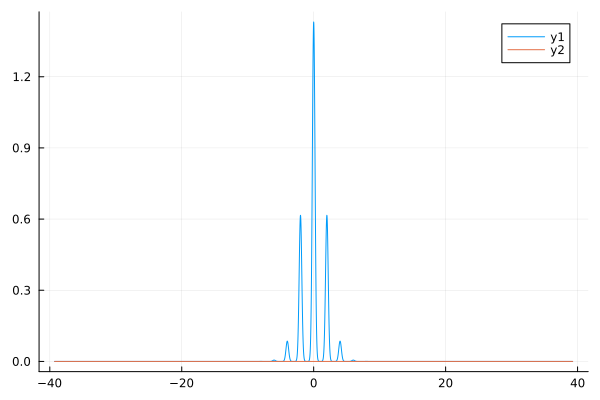

In [219]:
Plots.plot(ps, hcat(real.(psip0_ket.data), imag.(psip0_ket.data)))

In [220]:
psix0_ket = Txp * psip0_ket
psix0 = psix0_ket.data

5000-element Vector{ComplexF64}:
  1.5072887603505312e-16 + 1.1618234430168626e-14im
  -2.575736678465609e-15 + 1.1343863454350587e-14im
 -5.1899406221805645e-15 + 1.05559956978375e-14im
  -7.628294210513242e-15 + 9.268915692958316e-15im
   -9.77775078645607e-15 + 7.602788669556588e-15im
 -1.1597487946067966e-14 + 5.6249808241019316e-15im
  -1.307337485723259e-14 + 3.4193807789569794e-15im
 -1.4166944254704033e-14 + 1.1200744608948527e-15im
 -1.4900177432907962e-14 - 1.2149354556002038e-15im
 -1.5269149160697813e-14 - 3.489560727066627e-15im
 -1.5344513598720467e-14 - 5.649258334493307e-15im
  -1.513883148662985e-14 - 7.640002390155362e-15im
  -1.466466356411067e-14 - 9.418519857540135e-15im
                         ⋮
   1.460500005067217e-14 - 9.306665373405966e-15im
  1.5098009082704062e-14 - 7.542577606756687e-15im
  1.5352364061013818e-14 - 5.553762456923784e-15im
  1.5339803321335492e-14 - 3.4319350961509153e-15im
  1.4970831593548787e-14 - 1.1548110467955022e-15im
  1.42768507268

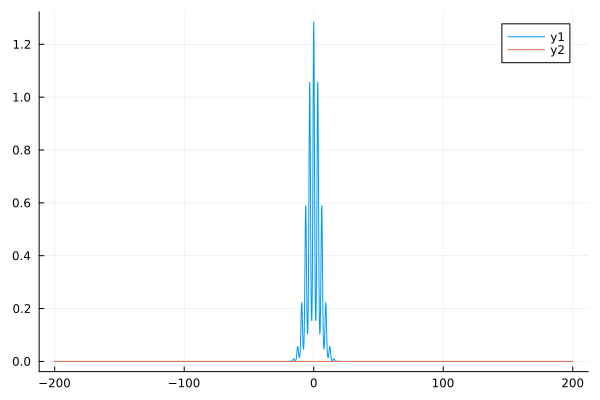

In [221]:
Plots.plot(xs, hcat(real.(psix0_ket.data), imag.(psix0_ket.data)))

t_max = 20.0
dt = 0.007
times = collect(0.0:dt:t_max)

In [222]:
times_slice = 1:length(times)

1:1502

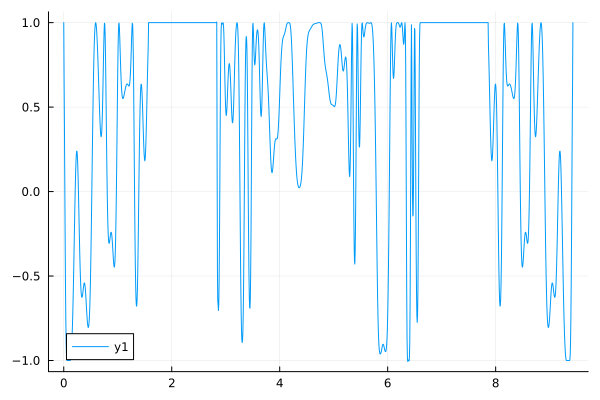

In [223]:
Plots.plot(times[times_slice], I.(times[times_slice]))

In [224]:
tout, psipt_ket = QO.timeevolution.schroedinger_dynamic(times[times_slice], psip0_ket, H_p)

([0.0, 0.006283185307179605, 0.01256637061435921, 0.018849555921538814, 0.02513274122871842, 0.031415926535898024, 0.03769911184307763, 0.043982297150257234, 0.05026548245743684, 0.05654866776461644  …  9.374512478311967, 9.380795663619148, 9.387078848926327, 9.393362034233506, 9.399645219540686, 9.405928404847867, 9.412211590155046, 9.418494775462225, 9.424777960769404, 9.431061146076585], QuantumOpticsBase.Ket{QuantumOpticsBase.MomentumBasis{-39.269908169872416, 39.269908169872416, Int64, Float64}, Vector{ComplexF64}}[Ket(dim=5000)
  basis: Momentum(pmin=-39.269908169872416, pmax=39.269908169872416, N=5000)
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=5000)
  basis: Momentum(pmin=-39.269908169

In [225]:
psip = hcat([psi_ket.data for psi_ket in psipt_ket]...)
popsp = abs2.(psip)

5000×1502 Matrix{Float64}:
 0.0  2.17281e-29  5.15976e-24  6.23485e-19  …  1.93583e-11  1.9468e-11
 0.0  1.33979e-29  3.16354e-24  3.78649e-19     1.21397e-11  1.18865e-11
 0.0  1.14312e-29  3.03043e-24  3.8416e-19      9.27847e-12  9.51596e-12
 0.0  2.32649e-29  5.89887e-24  7.36803e-19     1.63933e-11  1.61574e-11
 0.0  4.14677e-29  1.00752e-23  1.22998e-18     2.66266e-11  2.66482e-11
 0.0  9.39513e-29  2.18497e-23  2.6006e-18   …  5.22976e-11  5.26559e-11
 0.0  1.97113e-28  4.4587e-23   5.20615e-18     1.01369e-10  1.00773e-10
 0.0  3.1401e-28   6.96024e-23  8.00719e-18     1.46015e-10  1.46538e-10
 0.0  5.1485e-28   1.12271e-22  1.27461e-17     2.14383e-10  2.1553e-10
 0.0  8.05533e-28  1.72964e-22  1.93896e-17     3.03066e-10  3.01958e-10
 0.0  1.37503e-27  2.91101e-22  3.22353e-17  …  4.48601e-10  4.4943e-10
 0.0  1.94223e-27  4.05963e-22  4.44506e-17     5.57108e-10  5.58122e-10
 0.0  2.86302e-27  5.91012e-22  6.39881e-17     7.27053e-10  7.2509e-10
 ⋮                          

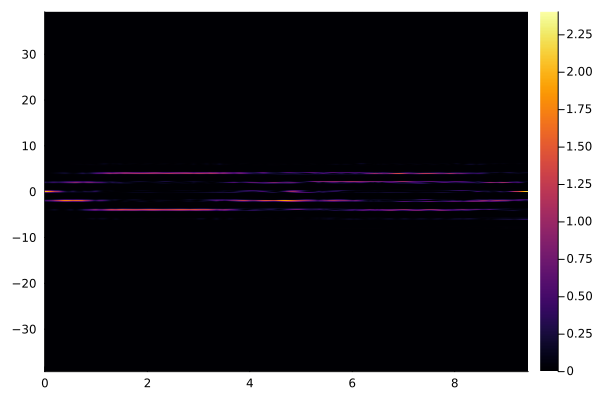

In [226]:
Plots.heatmap(tout, ps, popsp)#, c=Plots.cgrad([:black, :white], [0.05]))

In [227]:
psix = hcat([(Txp*psi_ket).data for psi_ket in psipt_ket]...)
popsx = abs2.(psix)

5000×1502 Matrix{Float64}:
 1.35006e-28  1.37146e-28  2.1613e-26   …  2.26352e-6  1.26245e-6  7.80843e-7
 1.35318e-28  1.14716e-28  2.54548e-26     9.28227e-6  7.08192e-6  5.5338e-6
 1.38365e-28  1.37896e-28  2.28616e-26     4.51499e-6  4.01198e-6  3.81648e-6
 1.44104e-28  1.21119e-28  2.27379e-26     2.9801e-6   1.79958e-6  1.03845e-6
 1.53407e-28  1.50731e-28  2.20055e-26     1.13125e-5  8.40047e-6  5.78824e-6
 1.66142e-28  1.4542e-28   1.81745e-26  …  8.24187e-6  7.13341e-6  5.90534e-6
 1.82605e-28  1.7999e-28   1.96582e-26     4.06037e-6  3.34903e-6  2.53971e-6
 2.01957e-28  1.87005e-28  1.32444e-26     1.14901e-5  9.29481e-6  6.87503e-6
 2.23491e-28  2.21139e-28  1.65753e-26     1.12796e-5  1.04987e-5  9.27421e-6
 2.45324e-28  2.37928e-28  8.96798e-27     5.43141e-6  5.36879e-6  5.03187e-6
 2.67368e-28  2.67328e-28  1.33565e-26  …  1.01941e-5  8.80619e-6  7.14967e-6
 2.87554e-28  2.86079e-28  5.72965e-27     1.27559e-5  1.24276e-5  1.18166e-5
 3.03761e-28  3.06343e-28  1.03405e-26

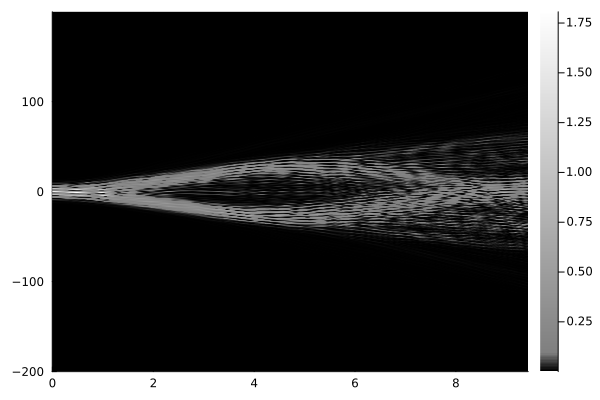

: 

In [228]:
Plots.heatmap(tout, xs, popsx, c=Plots.cgrad([:black, :white], [0.05]))

In [161]:
n_max = 5
vs = collect(LA.I(2*n_max+1))
vs = collect(LA.I(Nx)) * (1.0 + 0.0im)

200×200 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
    ⋮                             ⋱                        
 0.0+0.0im  0.0

In [162]:
sigma = 0.2
#psi0s = [momentum_comb(ps, vs[:,i], sigma) for i=1:size(vs)[2]]
psi0s = [vs[:,i] for i=1:size(vs)[2]]
psi0_kets = [QO.Ket(b_momentum, psi0) for psi0 in psi0s]

200-element Vector{QuantumOpticsBase.Ket{QuantumOpticsBase.MomentumBasis{-10.471975511965978, 10.471975511965978, Int64, Float64}, Vector{ComplexF64}}}:
 Ket(dim=200)
  basis: Momentum(pmin=-10.471975511965978, pmax=10.471975511965978, N=200)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 Ket(dim=200)
  basis: Momentum(pmin=-10.471975511965978, pmax=10.471975511965978, N=200)
 0.0 + 0.0im
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 Ke

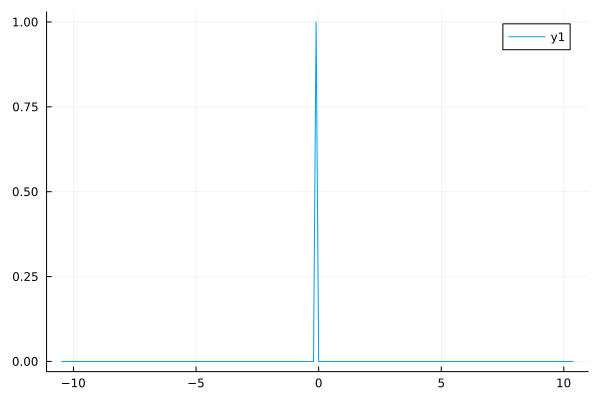

In [163]:
Plots.plot(ps, abs2.(psi0_kets[100].data))

In [166]:
psit_kets = []
for i=1:length(psi0s)
    tout, psit_ket = QO.timeevolution.schroedinger_dynamic(times[times_slice], psi0_kets[i], H_p)
    push!(psit_kets, psit_ket)
    println(i)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


LoadError: BoundsError: attempt to access 200-element Vector{QuantumOpticsBase.Ket{QuantumOpticsBase.MomentumBasis{-10.471975511965978, 10.471975511965978, Int64, Float64}, Vector{ComplexF64}}} at index [201]

In [167]:
psits = [hcat([psit_ket.data for psit_ket in psit_kets[i]]...) for i=1:length(psit_kets)]
popsts = [abs2.(psit) for psit in psits]

200-element Vector{Matrix{Float64}}:
 [1.0 0.9994032924504671 … 0.6042435724264061 0.6237492010670203; 0.0 5.242450326401291e-9 … 0.0019444004313938562 0.0020791898174179913; … ; 0.0 5.698952284913736e-9 … 4.347924308417742e-5 5.691556480453756e-5; 0.0 5.319471514578679e-9 … 0.00044503253528038863 0.0003750340067324339]
 [0.0 5.278978748295279e-9 … 0.0018273063936337138 0.002021570908985593; 1.0 0.9994081531581304 … 0.24833766095408372 0.24618996001196422; … ; 0.0 6.2204532333199296e-9 … 0.00031360310947883846 0.00028703369237647556; 0.0 5.619815769174839e-9 … 0.000489575432235234 0.00047294063548850745]
 [0.0 5.545753342969321e-9 … 0.0004311541282187656 0.0004964231091017422; 0.0 5.281148278102243e-9 … 0.002758265338023321 0.003037599591104409; … ; 0.0 6.96141708275415e-9 … 0.0014271860098205537 0.0014874461848209475; 0.0 6.1056167559621934e-9 … 0.0002683190197451214 0.00031406225465245]
 [0.0 5.995898795272441e-9 … 0.0005242472581921671 0.0005566161404195913; 0.0 5.5485337322783535e-

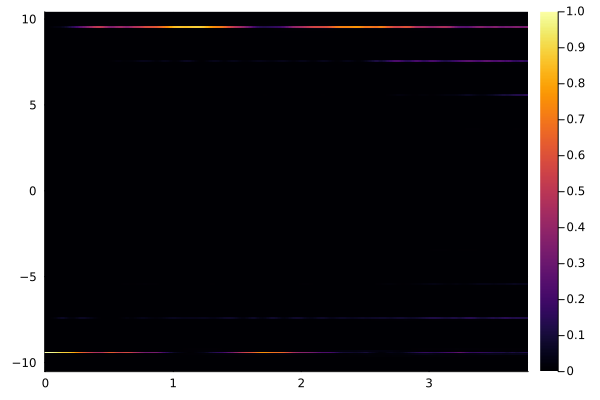

In [168]:
Plots.heatmap(tout, ps, popsts[11])#, c=Plots.cgrad([:black, :white], [0.05]))

In [169]:
UT = hcat([psit[:,end] for psit in psits]...)

200×200 Matrix{ComplexF64}:
     0.779769-0.125335im     …     0.0136744+0.00712632im
    0.0303219-0.0340554im         0.00873401-0.000459425im
   0.00807185-0.00968384im        0.00926061+0.0146649im
  -0.00905605-0.0141395im        -0.00353876+0.00377834im
  -0.00530818+0.000415713im        0.0104805+0.00448477im
  -0.00199621-0.0028439im    …   -0.00464998-0.0142377im
  -0.00863928-0.00183734im        -0.0129291+0.0157861im
   0.00443607+0.00550715im         0.0233629-0.00347342im
  -0.00225967+0.00419383im        -0.0033938-0.00567749im
 -0.000355977+0.00333865im       -0.00476712+0.00376507im
  -0.00123283-0.00347317im   …    0.00563701+0.00406592im
  -0.00256958-0.0105879im         0.00103105+0.00569382im
   -0.0033134+0.00899916im         0.0160533-0.00812336im
             ⋮               ⋱  
   0.00653697+0.0104179im        -0.00193479-0.0143758im
   -0.0044092-0.00189085im      -0.000164236+0.00145027im
   0.00641241+0.00286492im   …   -0.00403621-0.00839277im
  -0.00023845+

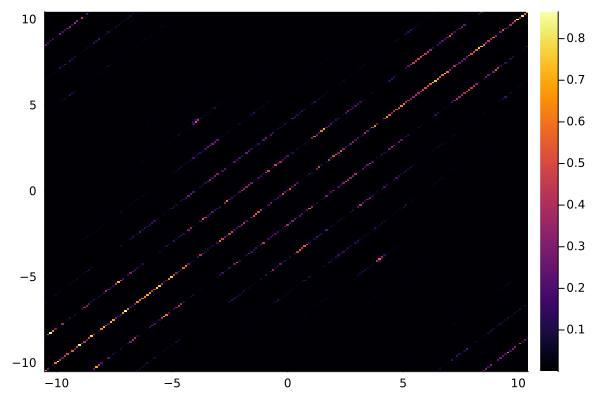

In [171]:
Plots.heatmap(ps, ps, abs2.(UT))#[end:-1:1,:])

In [172]:
import JLD2

In [174]:
JLD2.save("mirror_rollout2.jld2", Dict("tout" => tout, "UT" => UT))

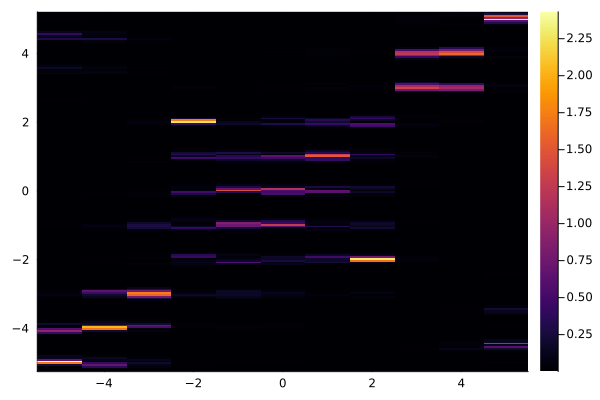

In [ ]:
Plots.heatmap(-n_max:n_max, ps/2, abs2.(UT))#[end:-1:1,:])